In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm

# Mnist dataset

In [2]:
import os
import gzip

In [3]:
def load_mnist(path, kind='train'):
    """Load MNIST data from `path`"""
    labels_path = os.path.join(path,
                               '%s-labels-idx1-ubyte.gz'
                               % kind)
    images_path = os.path.join(path,
                               '%s-images-idx3-ubyte.gz'
                               % kind)

    with gzip.open(labels_path, 'rb') as lbpath:
        labels = np.frombuffer(lbpath.read(), dtype=np.uint8,
                               offset=8)

    with gzip.open(images_path, 'rb') as imgpath:
        images = np.frombuffer(imgpath.read(), dtype=np.uint8,
                               offset=16).reshape(len(labels), 784)

    return images, labels


In [4]:
allX, ally = load_mnist('Weights/Ques2/', kind='train')
allX_2, ally_2 = load_mnist('Weights/Ques2/', kind='t10k')

In [5]:
X = allX
X = np.concatenate((X, allX_2), axis=0)
y = ally
y = np.concatenate((y, ally_2), axis=0)
X.shape, y.shape


((70000, 784), (70000,))

In [10]:
with open('Weights/Ques2/extracted/t10k-images-idx3-ubyte', 'rb') as f:
    data = f.read()
    test_images = np.frombuffer(data, dtype=np.uint8, offset=16).reshape(10000, 784)

In [11]:
test_images.shape

(10000, 784)

In [10]:
def train_test_split(df, trainSize=0.8, testSize=0.2, random_state=42):
    validSize = 1 - trainSize - testSize
    indices = np.arange(df.shape[0])
    np.random.seed(random_state)
    np.random.shuffle(indices)
    trainData = df.iloc[indices[:int(
        trainSize*df.shape[0])]].reset_index(drop=True)
    validData = df.iloc[indices[int(
        trainSize*df.shape[0]):int((trainSize+validSize)*df.shape[0])]].reset_index(drop=True)
    testData = df.iloc[indices[int(
        (trainSize+validSize)*df.shape[0]):]].reset_index(drop=True)
    if validSize == 0:
        return trainData, testData
    else:
        return trainData, validData, testData


In [11]:
X = pd.DataFrame(X)
y = pd.DataFrame(y)

In [12]:
allData = pd.concat([X, y], axis=1)
print(allData.shape)
allData.head()

(70000, 785)


,0,1,2,3,4,5,6,7,8,9,...,775,776,777,778,779,780,781,782,783,0
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,5
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,4
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,9


In [14]:
trainData, validData, testData = train_test_split(allData, trainSize=0.7, testSize=0.2, random_state=42)

In [15]:
trainData.shape, validData.shape, testData.shape

((49000, 785), (7000, 785), (14000, 785))

In [16]:
trainX = trainData.iloc[:, :-1]
trainY = trainData.iloc[:, -1]
validX = validData.iloc[:, :-1]
validY = validData.iloc[:, -1]
testX = testData.iloc[:, :-1]
testY = testData.iloc[:, -1]

In [17]:
def softmax(x):
    """Compute softmax values for each sets of scores in x."""
    e_x = np.exp(x)
    return e_x / np.sum(e_x, axis=1, keepdims=True)

In [18]:
class MyNeuralNetwork:
    def __init__(self, N_inputs, N_outputs, N_layers=2, Layer_sizes=[10, 5], activation="sigmoid", learning_rate=0.1, weight_init="random", batch_size=1, num_epochs=200):
        """
        N_inputs: input size
        N_outputs: outputs size
        N_layers: number of hidden layers
        Layer_sizes: list of hidden layer sizes
        activation: activation function to be used (ReLu, Leaky ReLu, sigmoid, linear, tanh, softmax)
        learning_rate: learning rate
        weight_init: weight initialization (zero, random, normal)
        batch_size: batch size
        num_epochs: number of epochs
        """
        self.N_inputs = N_inputs
        self.N_outputs = N_outputs
        self.N_layers = N_layers
        self.Layer_sizes = Layer_sizes
        self.activation = activation
        self.learning_rate = learning_rate
        self.weight_init = weight_init
        self.batch_size = batch_size
        self.num_epochs = num_epochs
        np.random.seed(0)

        model = {}
        if weight_init == "zero":
            model['W1'] = np.zeros((N_inputs, Layer_sizes[0]))
            model['b1'] = np.zeros((1, Layer_sizes[0]))
            for i in range(1, N_layers):
                model['W' + str(i+1)] = np.zeros((Layer_sizes[i-1], Layer_sizes[i]))
                model['b' + str(i+1)] = np.zeros((1, Layer_sizes[i]))
            model['W' + str(N_layers+1)] = np.zeros((Layer_sizes[-1], N_outputs))
            model['b' + str(N_layers+1)] = np.zeros((1, N_outputs))
        elif weight_init == "random":
            model['W1'] = np.random.randn(N_inputs, Layer_sizes[0])
            model['W1'] *= 0.01
            # model['W1'] = np.random.randn(N_inputs, Layer_sizes[0])
            model['b1'] = np.zeros((1, Layer_sizes[0]))
            for i in range(1, N_layers):
                model['W' + str(i+1)] = np.random.randn(Layer_sizes[i-1], Layer_sizes[i])
                model['W' + str(i+1)] *= 0.00000001
                # model['W' + str(i+1)] = np.random.randn(Layer_sizes[i-1], Layer_sizes[i])
                model['b' + str(i+1)] = np.zeros((1, Layer_sizes[i]))
            model['W' + str(N_layers+1)] = np.random.randn(Layer_sizes[-1], N_outputs)
            model['W' + str(N_layers+1)] *= 0.00000001
            # model['W' + str(N_layers+1)] = np.random.randn(Layer_sizes[-1], N_outputs)
            model['b' + str(N_layers+1)] = np.zeros((1, N_outputs))
        elif weight_init == "normal":
            model['W1'] = np.random.normal(0, 1, (N_inputs, Layer_sizes[0]))*0.00000001
            model['b1'] = np.zeros((1, Layer_sizes[0]))
            for i in range(1, N_layers):
                model['W' + str(i+1)] = np.random.normal(0, 1, (Layer_sizes[i-1], Layer_sizes[i]))*0.01
                model['b' + str(i+1)] = np.zeros((1, Layer_sizes[i]))
            model['W' + str(N_layers+1)] = np.random.normal(0, 1, (Layer_sizes[-1], N_outputs))*0.01
            model['b' + str(N_layers+1)] = np.zeros((1, N_outputs))
        else:
            print("Invalid weight initialization")
            return

        self.model = model
        self.activationOutputs = None
    
    def relu_forward(self, X):
        """
        ReLu activation function for forward propagation
        X: input
        return: output after applying the relu function
        """
        return np.maximum(X, 0)

    def relu_backward(self, X):
        """
        ReLu activation function for backpropagation
        X: input
        return: output after applying the gradient of relu function
        """
        return np.where(X > 0, 1, 0)

    def leaky_relu_forward(self, X):
        """
        Leaky ReLu activation function
        X: input
        return: output after applying the Leaky ReLu function
        """
        return np.maximum(X, 0.01*X)

    def leaky_relu_backward(self, X):
        """
        Leaky ReLu activation function
        X: input
        return: output after applying the gradient of Leaky ReLu function
        """
        return np.where(X > 0, 1, 0.01)

    def sigmoid_forward(self, X):
        """
        Sigmoid activation function
        X: input
        return: output after applying the sigmoid function
        """
        return 1/(1+np.exp(-X))

    def sigmoid_backward(self, X):
        """
        Sigmoid activation function
        X: input
        return: output after applying the gradient of sigmoid function
        """
        return self.sigmoid_forward(X)*(1-self.sigmoid_forward(X))
        # return X*(1-X)

    def linear_forward(self, X):
        """
        Linear activation function
        X: input
        return: output after applying the linear function
        """
        return X

    def linear_backward(self, X):
        """
        Linear activation function
        X: input
        return: output after applying the gradient of linear function
        """
        return 1

    def tanh_forward(self, X):
        """
        Tanh activation function
        X: input
        return: output after applying the tanh function
        """
        return (np.exp(X)-np.exp(-X))/(np.exp(X)+np.exp(-X))
    
    def tanh_backward(self, X):
        """
        Tanh activation function
        X: input
        return: output after applying the gradient of tanh function
        """
        return 1-self.tanh_forward(X)**2
        # return 1-X**2

    def softmax_forward(self, X):
        """
        Softmax activation function
        X: input
        return: output after applying the softmax function
        """
        return np.exp(X)/np.sum(np.exp(X), axis=1, keepdims=True)

    # softmax implemetatation incomplete
    def softmax_backward(self, X):
        """
        Softmax activation function
        X: input
        return: output after applying the gradient of softmax function
        """
        softmax = self.softmax_forward(X)
        e = np.ones((softmax.shape[0], 1))
        v1 = np.dot(softmax, e.T)
        i = np.eye(softmax.shape[0])
        v2 = i - np.dot(e, softmax.T)
        return np.multiply(v1, v2)

    def forward(self, X):
        """
        Forward propagation
        X: input
        return: output after applying the activation function
        """
        if self.activation == "relu":
            currentActivationFuntion = self.relu_forward
        elif self.activation == "leaky_relu":
            currentActivationFuntion = self.leaky_relu_forward
        elif self.activation == "sigmoid":
            currentActivationFuntion = self.sigmoid_forward
        elif self.activation == "linear":
            currentActivationFuntion = self.linear_forward
        elif self.activation == "tanh":
            currentActivationFuntion = self.tanh_forward
        elif self.activation == "softmax":
            currentActivationFuntion = self.softmax_forward
        else:
            raise ValueError("Invalid activation function")
        
        self.activationOutputs = {}
        
        self.activationOutputs['Z1'] = np.dot(X, self.model['W1']) + self.model['b1']
        self.activationOutputs['A1'] = currentActivationFuntion(self.activationOutputs['Z1'])
        # self.activationOutputs['A1'] = np.tanh(self.activationOutputs['Z1'])

        for i in range(2, self.N_layers+1):
            self.activationOutputs['Z' + str(i)] = np.dot(self.activationOutputs['A' + str(i-1)], self.model['W' + str(i)]) + self.model['b' + str(i)]
            self.activationOutputs['A' + str(i)] = currentActivationFuntion(self.activationOutputs['Z' + str(i)])

        self.activationOutputs['Z' + str(self.N_layers+1)] = np.dot(self.activationOutputs['A' + str(self.N_layers)], self.model['W' + str(self.N_layers+1)]) + self.model['b' + str(self.N_layers+1)]
        self.activationOutputs['A' + str(self.N_layers+1)] = currentActivationFuntion(self.activationOutputs['Z' + str(self.N_layers+1)])

        return self.activationOutputs['A' + str(self.N_layers+1)]


    def backward(self, X, Y):
        """
        Backward propagation
        X: input
        Y: output
        """
        if self.activation == "relu":
            currentActivationFuntion = self.relu_backward
        elif self.activation == "leaky_relu":
            currentActivationFuntion = self.leaky_relu_backward
        elif self.activation == "sigmoid":
            currentActivationFuntion = self.sigmoid_backward
        elif self.activation == "linear":
            currentActivationFuntion = self.linear_backward
        elif self.activation == "tanh":
            currentActivationFuntion = self.tanh_backward
        elif self.activation == "softmax":
            currentActivationFuntion = self.softmax_backward
        else:
            raise ValueError("Invalid activation function")

        # computing the gradients
        self.gradients = {}
        self.gradients['delta' + str(self.N_layers+1)] = self.activationOutputs['A' + str(self.N_layers+1)] - Y
        self.gradients['dW' + str(self.N_layers+1)] = np.dot(self.activationOutputs['A' + str(self.N_layers)].T, self.gradients['delta' + str(self.N_layers+1)])
        self.gradients['db' + str(self.N_layers+1)] = np.sum(self.gradients['delta' + str(self.N_layers+1)], axis=0)
        
        for i in range(self.N_layers, 1, -1):
            self.gradients['delta' + str(i)] = np.dot(self.gradients['delta' + str(i+1)], self.model['W' + str(i+1)].T) * currentActivationFuntion(self.activationOutputs['Z' + str(i)])
            self.gradients['dW' + str(i)] = np.dot(self.activationOutputs['A' + str(i-1)].T, self.gradients['delta' + str(i)])
            self.gradients['db' + str(i)] = np.sum(self.gradients['delta' + str(i)], axis=0)

        self.gradients['delta1'] = np.dot(self.gradients['delta2'], self.model['W2'].T) * currentActivationFuntion(self.activationOutputs['Z1'])
        self.gradients['dW1'] = np.dot(X.T, self.gradients['delta1'])
        self.gradients['db1'] = np.sum(self.gradients['delta1'], axis=0)

        # updating the model parameters
        for i in range(1, self.N_layers+2):
            self.model['W' + str(i)] -= self.learning_rate * self.gradients['dW' + str(i)]
            self.model['b' + str(i)] -= self.learning_rate * self.gradients['db' + str(i)]

    def oneHotEncoder(self, y, n_classes):
        """
        One hot encoder
        y: input
        return: encoded output
        """
        m = y.shape[0]
        y_oht = np.zeros((m, n_classes))
        y_oht[np.arange(m), y] = 1
        return y_oht

    def crossEntropyLoss(self, y_oht, y_prob):
        """
        Cross entropy loss
        y_oht: one hot encoded output
        y_prob: probabilities for classes
        return: cross entropy loss
        """
        return -np.mean(y_oht * np.log(y_prob))

    def fit(self, X, y, logs=True):
        """
        Fit the model to the data
        X: input
        Y: output
        epochs: number of epochs
        """
        losses = []
        classes = self.N_outputs
        batchSize = self.batch_size
        y_oht = self.oneHotEncoder(y, classes)
        for i in range(self.num_epochs):
            for j in range(0, X.shape[0], batchSize):
                X_batch = X[j:j+batchSize]
                y_batch = y_oht[j:j+batchSize]
                y_ = self.forward(X_batch)
                self.backward(X_batch, y_batch)
            y_ = self.forward(X)
            loss = self.crossEntropyLoss(y_oht, y_)
            losses.append(loss)
            if logs:
                print("Epoch: {}, Loss: {}".format(i, loss))
        return losses

    def predict_proba(self, X):
        """
        Predict probabilities
        X: input
        return: probabilities
        """
        return self.forward(X)

    def predict(self, X):
        """
        Predict classes
        X: input
        return: classes
        """
        return np.argmax(self.forward(X), axis=1)

    def score(self, X, y):
        """
        Score the model
        X: input
        Y: output
        return: accuracy
        """
        y_pred = self.predict(X)
        return np.mean(y_pred == y)*100

# part a

In [118]:
model = MyNeuralNetwork(N_inputs=784, N_outputs=10, N_layers=1, Layer_sizes=[100], activation="relu", learning_rate=0.08, weight_init="random", num_epochs=10, batch_size=trainX.shape[0])

In [119]:
trainX_ = trainX.values
b

In [121]:
trainX = trainX.values.astype(np.float128)
trainY = trainY.values.astype(np.float128)

In [122]:
lossObtained = model.fit(trainX, trainY, logs=True)

IndexError: arrays used as indices must be of integer (or boolean) type

/var/folders/fc/z3ktrz354nddfg1wt432tbm80000gn/T/ipykernel_49070/764094008.py:101: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))


Accuracy: 11.521428571428572


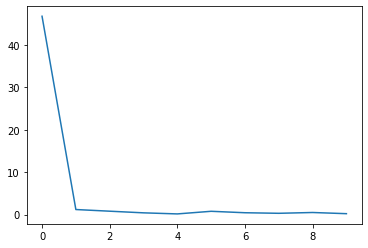

In [117]:
print("Accuracy: {}".format(model.score(testX, testY)))
plt.plot(lossObtained)
plt.show()

In [44]:
from sklearn.neural_network import MLPClassifier

In [89]:
mlp = MLPClassifier(verbose=True, max_iter=20)

In [98]:
mlp = MLPClassifier(hidden_layer_sizes=(100,), max_iter=150, learning_rate_init=0.08, activation='relu', verbose=True)

In [99]:
mlp.fit(allX, ally)

Iteration 1, loss = 2.81702758
Iteration 2, loss = 2.29174322


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:619: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")


MLPClassifier(learning_rate_init=0.08, max_iter=150, verbose=True)

In [91]:
mlp.score(testX, testY)

0.9710714285714286

In [93]:
mlp.activation

'relu'

In [94]:
mlp.get_params

<bound method BaseEstimator.get_params of MLPClassifier(max_iter=20, verbose=True)>

In [95]:
mlp.n_layers_

3

In [96]:
mlp.n_outputs_

10

In [104]:
mlp.learning_rate_init

0.08

In [97]:
mlp.hidden_layer_sizes

(100,)

In [78]:
mlp.score(validX, validY), mlp.score(trainX, trainY)

(0.10285714285714286, 0.10497959183673469)

In [1]:
vinayTrainX = [[0, 0], [0, 1], [1, 0], [1, 1]]
vinayTrainY = [0, 1, 1, 1]

In [31]:
model = MyNeuralNetwork(N_inputs=2, N_outputs=2, N_layers=1, Layer_sizes=[5], activation="sigmoid", learning_rate=0.1, weight_init="random", num_epochs=100, batch_size=4)

In [39]:
vinayTrainY = np.array(vinayTrainY).reshape(4, 1)
vinayTrainX = np.array(vinayTrainX).reshape(4, 2)
vinayTrainY.shape,vinayTrainX.shape

((4, 1), (4, 2))

In [40]:
model.fit(vinayTrainX, vinayTrainY, logs=True)

Epoch: 0, Loss: 0.007630946930713027
Epoch: 1, Loss: 0.007545724145032244
Epoch: 2, Loss: 0.00746228427390646
Epoch: 3, Loss: 0.007380573220953148
Epoch: 4, Loss: 0.007300539027734195
Epoch: 5, Loss: 0.007222131770081296
Epoch: 6, Loss: 0.007145303460358473
Epoch: 7, Loss: 0.007070007955271976
Epoch: 8, Loss: 0.0069962008688648665
Epoch: 9, Loss: 0.006923839490360749
Epoch: 10, Loss: 0.00685288270654557
Epoch: 11, Loss: 0.006783290928399731
Epoch: 12, Loss: 0.006715026021711789
Epoch: 13, Loss: 0.006648051241425602
Epoch: 14, Loss: 0.006582331169489653
Epoch: 15, Loss: 0.006517831655993464
Epoch: 16, Loss: 0.006454519763390485
Epoch: 17, Loss: 0.006392363713622457
Epoch: 18, Loss: 0.006331332837969828
Epoch: 19, Loss: 0.006271397529467371
Epoch: 20, Loss: 0.00621252919773396
Epoch: 21, Loss: 0.006154700226074842
Epoch: 22, Loss: 0.006097883930725332
Epoch: 23, Loss: 0.006042054522112215
Epoch: 24, Loss: 0.005987187068018646
Epoch: 25, Loss: 0.005933257458543711
Epoch: 26, Loss: 0.00588

[0.007630946930713027,
 0.007545724145032244,
 0.00746228427390646,
 0.007380573220953148,
 0.007300539027734195,
 0.007222131770081296,
 0.007145303460358473,
 0.007070007955271976,
 0.0069962008688648665,
 0.006923839490360749,
 0.00685288270654557,
 0.006783290928399731,
 0.006715026021711789,
 0.006648051241425602,
 0.006582331169489653,
 0.006517831655993464,
 0.006454519763390485,
 0.006392363713622457,
 0.006331332837969828,
 0.006271397529467371,
 0.00621252919773396,
 0.006154700226074842,
 0.006097883930725332,
 0.006042054522112215,
 0.005987187068018646,
 0.005933257458543711,
 0.005880242372756806,
 0.005828119246952312,
 0.00577686624441481,
 0.005726462226614194,
 0.0056768867257509575,
 0.005628119918579529,
 0.0055801426014405915,
 0.005532936166438941,
 0.005486482578704834,
 0.005440764354683724,
 0.005395764541399454,
 0.005351466696640751,
 0.005307854870024673,
 0.005264913584891192,
 0.005222627820986367,
 0.005180982997896615,
 0.005139964959194217,
 0.005099559

In [38]:
model.predict([[0, 1]])

array([0])

In [28]:
def testoneHotEncoder(y, n_classes):
    """
        One hot encoder
        y: input
        return: encoded output
        """
    m = y.shape[0]
    y_oht = np.zeros((m, n_classes))
    y_oht[np.arange(m), y] = 1
    return y_oht


In [30]:
oh = testoneHotEncoder(vinayTrainY, 1)
oh

IndexError: index 1 is out of bounds for axis 1 with size 1